# Statistical analysis

## Introduction

Statistical analysis usually encompasses 3 activities in a data science workflow. These are (a) descriptive analysis, (b) hypothesis testing and (c) statistical modeling. Descriptive analysis refers to a description of the data, which includes computing summary statistics and drawing plots. Hypothesis testing usually refers to statistically seeing if two (or more) groups are different from each other based on some metrics. Modeling refers to fitting a curve to the data to describe the relationship patterns of different variables in a data set.

In terms of Python packages that can address these three tasks:

| Task                   | Packages               |
| :---------------------- | ---------------------- |
| Descriptive statistics | pandas, numpy, matplotlib, seaborn          |
| Hypothesis testing     | scipy, statsmodels     |
| Modeling               | statsmodels, lifelines, scikit-learn |


## Descriptive statistics

Descriptive statistics that are often computed are the mean, median, standard deviation, inter-quartile range, pairwise correlations, and the like. Most of these functions are available in `numpy`, and hence are available in `pandas`. We have already seen how we can compute these statistics and have even computed grouped statistics. For example, we will compute these using the diamonds dataset

In [8]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

In [9]:
diamonds = pd.read_csv('data/diamonds.csv.gz')

In [10]:
diamonds.groupby('color')['price'].agg([np.mean, np.median, np.std])

,mean,median,std
color,,,
D,3169.954096,1838.0,3356.590935
E,3076.752475,1739.0,3344.158685
F,3724.886397,2343.5,3784.992007
G,3999.135671,2242.0,4051.102846
H,4486.669196,3460.0,4215.944171
I,5091.874954,3730.0,4722.387604
J,5323.818020,4234.0,4438.187251


There were other examples we saw yesterday along these lines. Refer to both the `python_tools_ds` and `python_pandas` documents

##  Classical hypothesis testing

Python has the tools to do classic hypothesis testing. Several functions are available in the `scipy.stats` module. The commonly used tests that are available are as follows:

| Function           | Test                                                    |
| :----------------- | ------------------------------------------------------- |
| `ttest_1samp`      | One-sample t-test                                       |
| `ttest_ind`        | Two-sample t-test                                       |
| `ttest_rel`        | Paired t-test                                           |
| `wilcoxon`         | Wilcoxon signed-rank test (nonparametric paired t-test) |
| `mannwhitneyu`         | Wilcoxon rank-sum test (nonparametric 2-sample t-test)  |
| `chi2_contingency` | Chi-square test for independence                        |
| `fisher_exact`     | Fisher's exact test on a 2x2 contingency table          |
| `f_oneway`         | One-way ANOVA                                           |
| `pearsonr`         | Testing for correlation                                 |
|                    |                                                         |

There are also several tests in `statsmodels.stats`

| Functions           | Tests                                 |
| :------------------ | ------------------------------------- |
| `proportions_ztest` | Test for difference in proportions    |
| `mcnemar`           | McNemar's test                        |
| `sign_test`         | Sign test                             |
| `multipletests`     | p-value correction for multiple tests |
| `fdrcorrection`     | p-value correction by FDR             |
|                     |                                       |

Let us look at a breast cancer proteomics experiment to illustrate this. The experimental data contains protein expression for over 12 thousand proteins, along with clinical data. We can ask, for example, whether a particular protein expression differs by ER status. 

In [11]:
brca = pd.read_csv('data/brca.csv')
brca.head()

,Unnamed: 0,Complete TCGA ID,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,...,NP_001193600,NP_061134,NP_932347,NP_003593,NP_997203,NP_001191293,NP_775791,NP_004065,NP_068752,NP_219494
0,0,TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,...,NaN,NaN,1.153614,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,TCGA-BH-A18Q,FEMALE,56,Negative,Negative,Negative,T2,T_Other,N1,...,0.048144,NaN,-0.881872,2.527072,-8.111243,-16.029761,-2.046065,-1.778435,NaN,-3.069752
2,2,TCGA-A7-A0CE,FEMALE,57,Negative,Negative,Negative,T2,T_Other,N0,...,0.644347,NaN,1.625952,NaN,NaN,NaN,-1.306238,NaN,NaN,NaN
3,3,TCGA-D8-A142,FEMALE,74,Negative,Negative,Negative,T3,T_Other,N0,...,-5.107629,-0.97598,NaN,2.508629,-12.337110,-9.546530,-4.066584,NaN,NaN,NaN
4,4,TCGA-AO-A0J6,FEMALE,61,Negative,Negative,Negative,T2,T_Other,N0,...,-1.043420,NaN,NaN,NaN,-3.231339,NaN,NaN,NaN,NaN,-3.753616


We will use both the t-test and the Wilcoxon rank-sum test, the nonparametric equivalent. 

We will first do the classical t-test, that is available in the `scipy` package.

In [12]:
import scipy as sc
import statsmodels as sm
test_probe = 'NP_001193600'

tst = sc.stats.ttest_ind(brca[brca['ER Status']=='Positive'][test_probe], # Need [] since names have spaces
                   brca[brca['ER Status']=='Negative'][test_probe], 
                  nan_policy = 'omit')
np.round(tst.pvalue, 3)

0.277

We will now do the Wilcoxon test, also known as the Mann-Whitney U test. 

In [13]:
tst = sc.stats.mannwhitneyu(brca[brca['ER Status']=='Positive'][test_probe], # Need [] since names have spaces
                   brca[brca['ER Status']=='Negative'][test_probe], 
                  alternative = 'two-sided')
np.round(tst.pvalue, 3)

0.996

We will come back to this when we look at permutation tests below. 

## Simulation and inference

Hypothesis testing is one of the areas where statistics is often used. There are functions for a lot of the standard statistical tests in `scipy` and `statsmodels`. However, I'm going to take a little detour to see if we can get some understanding of hypothesis tests using the powerful simulation capabilities of Python. We'll visit the in-built functions available in `scipy` and `statsmodels` as well.

### Simulation and hypothesis testing

**Question:** You have a coin and you flip it 100 times. You get 54 heads. How likely is it that you have a fair coin?

We can simulate this process, which is random, using Python. The process of heads and tails from coin tosses can be modeled as a [**binomial** distribution](https://en.wikipedia.org/wiki/Binomial_distribution). We can repeat this experiment many many times on our computer, making the assumption that we have a fair coin, and then seeing how likely what we observed is under that assumption. 

> Simulation under reasonable assumptions is a great way to understand our data and the underlying data generating processes. In the modern era, it has most famously been used by Nate Silver of ESPN to simulate national elections in the US. There are many examples in engineering where simulations are done to understand a technology and figure out its tolerances and weaknesses, like in aircraft testing. It is also commonly used in epidemic modeling to help understand how an epidemic would spread under different conditions. 

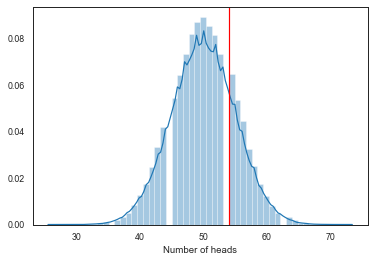

In [14]:
rng = np.random.RandomState(205) # Seed the random number generator

x = rng.binomial(100, 0.5, 100000) # Simulate 100,000 experiments of tossing a fair coin 100 times

sns.distplot(x, kde=True, rug=False)
plt.axvline(54, color = 'r'); # What we observed
plt.xlabel('Number of heads');

In [15]:
# We convert to pd.Series to take advantage of the `describe` function.
pd.Series(x).describe() 

count    100000.000000
mean         49.995590
std           5.011938
min          27.000000
25%          47.000000
50%          50.000000
75%          53.000000
max          72.000000
dtype: float64

What we see from the histogram and the description of the data above is the patterns in data we would expect if we repeated this random experiment. We can already make some observations. First, we do see that the average number of heads we expect to get is 50, which validates that our experiment is using a fair coin. Second, we can reasonably get as few as 27 heads and as many as 72 heads even with a fair coin. In fact, we could look at what values we would expect to see 95% of the time.

In [16]:
np.quantile(x, [0.025, 0.975])

array([40., 60.])

This says that 95% of the time we'll see values between 40 and 60. (This is **not** a confidence interval. This is the actual results of a simulation study. A confidence interval would be computed based on a **single** experiment, assuming a binomial distribution. We'll come to that later). 

So how likely would we be to see the 54 heads in 100 tosses assuming a fair coin? This can be computed as the proportion of experiments

In [17]:
np.mean(x > 54) # convince yourself of this

0.18456

This is what would be considered the *p-value* for the test that the coin is fair. 

> The p-value of a statistical hypothesis test is the likelihood that we would see an outcome at least as extreme as we observed under the assumption that the null hypothesis (H<sub>0</sub>) that we chose is actually true. 
>
> In our case, that null hypothesis is that the coin we're tossing is fair. The p-value **only** gives evidence against the null hypothesis, but does **not** give evidence for the null hypothesis. In other words, if the p-value is small (smaller than some threshold we deem reasonable), then we can claim evidence against the null hypothesis, but if the p-value is large, we cannot say the null hypothesis is true. 

What happens if we increase the number of tosses, and we look at the proportion of heads. We observe 54% heads.

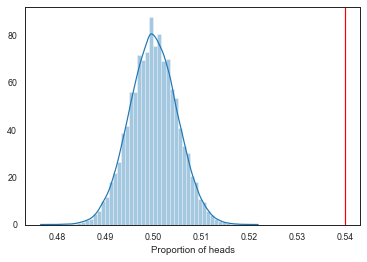

In [18]:
rng = np.random.RandomState(205)
x = rng.binomial(10000, 0.5, 100000)/10000
sns.distplot(x)
plt.axvline(0.54, color = 'r')
plt.xlabel('Proportion of heads');

In [19]:
pd.Series(x).describe()

count    100000.000000
mean          0.499991
std           0.004994
min           0.478100
25%           0.496600
50%           0.500000
75%           0.503400
max           0.520300
dtype: float64

Well, that changed the game significantly. If we up the number of coin tosses per experiment to 10,000, so 100-fold increase, then we do not see very much variation in the proportion of tosses that are heads. 

>This is expected behavior because of a statistical theorem called the *Law of Large Numbers*, which essentially says that if you do larger and larger sized random experiments with the same experimental setup, your estimate of the true population parameter (in this case the true chance of getting a head, or 0.5 for a fair coin) will become more and more precise. 

Now we see that for a fair coin, we should reasonably see between 47.8% and 52% of tosses should be heads. This is quite an improvement from the 27%-72% range we saw with 100 tosses. 

We can compute our p-value in the same way as before.

In [20]:
np.mean(x > 0.54)

0.0

So we would never see 54% of our tosses be heads if we tossed a fair coin 10,000 times. Now, with a larger experiment, we would **reject** our null hypothesis H<sub>0</sub> that we have a fair coin. 

So same observation, but more data, changes our *inference* from not having sufficient evidence to say that the coin isn't fair to saying that it isn't fair quite definitively. This is directly due to the increased precision of our estimates and thus our ability to differentiate between much smaller differences in the truth. 

Let's see a bit more about what's going on here. Suppose we assume that the coin's true likelihood of getting a head is really 0.55, so a very small bias towards heads.

> Food for thought: Is the difference between 0.50 and 0.54 worth worrying about? It probably depends. 

We're going to compare what we would reasonably see over many repeated experiments given the coin has a 0.50 (fair) and a 0.55 (slightly biased) chance of a head. First, we'll do experiments of 100 tosses of a coin.

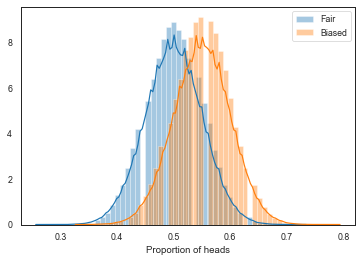

In [21]:
rng = np.random.RandomState(205)
x11 = rng.binomial(100, 0.5, 100000)/100 # Getting proportion of heads
x12 = rng.binomial(100, 0.55, 100000)/100 

sns.distplot(x11, label = 'Fair')
sns.distplot(x12, label = 'Biased')
plt.xlabel('Proportion of heads')
plt.legend();

We see that there is a great deal of overlap in the potential outcomes over 100,000 repetitions of these experiments, so we have a lot of uncertainty about which model (fair or biased) is the truth. 

Now, if we up our experiment to 10,000 tosses of each coin, and again repeat the experiment 100,000 times, 

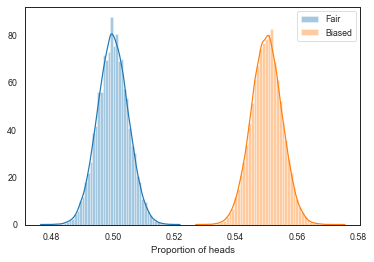

In [22]:
rng = np.random.RandomState(205)
x21 = rng.binomial(10000, 0.5, 100000)/10000
x22 = rng.binomial(10000, 0.55, 100000)/10000

sns.distplot(x21, label = 'Fair')
sns.distplot(x22, label = 'Biased')
plt.xlabel('Proportion of heads')
plt.legend();

We now find almost no overlap between the potential outcomes, so we can very easily distinguish the two models. This is part of what gathering more data (number of tosses) buys you. 

We typically measure this ability to distinguish between two models using concepts of *statistical power*, which is the likelihood that we would find an observation at least as extreme as what we observed, under the **alternative** model (in this case, the biased coin model). We can calculate the statistical power quite easily for the two sets of simulated experiments. Remember, we observed 54% heads in our one instance of each experiment that we actually observed. By doing simulations, we're "playing God" and seeing what could have happened, but in practice we only do the experiment once (how many clinical trials of an expensive drug would you really want to do?). 

In [23]:
pval1 = np.mean(x11 > 0.54)
pval2 = np.mean(x21 > 0.54)

power1 = np.mean(x12 > 0.54)
power2 = np.mean(x22 > 0.54)

print('The p-value when n=100 is ', np.round(pval1, 2))
print('The p-value when n=10,000 is ', np.round(pval2, 2))
print('Statistical power when n=100 is ', np.round(power1, 2))
print('Statistical power when n=10,000 is ', np.round(power2, 2))

The p-value when n=100 is  0.18
The p-value when n=10,000 is  0.0
Statistical power when n=100 is  0.54
Statistical power when n=10,000 is  0.98


So as *n* goes up, the p-value for the same experimental outcome goes down and the statistical power goes up. This is a general rule with increasing sample size. 

This idea can be used to design a two-armed experiment. Suppose we are looking at the difference in proportion of mice who gained weight between a wild-type mouse and a knockout variant. Since mice are expensive, let's limit the number of mice we'll use in each arm to 10. We expect 30% of the wild-type mice to gain weight, and expect a higher proportion of the knockouts will gain weight. This is again the setup for a binomial experiment, with the number of "coin tosses" being 10 for each of the arms. We're going to do two sets of experiments, one for the WT and one for the KO, and see the difference in proportions of weight gain ('heads') between them, and repeat it 100,000 times. 

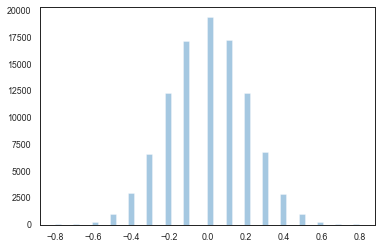

In [24]:
rng = np.random.RandomState(304)
N = 10
weight_gain_wt0 = rng.binomial(N, 0.3, 100000)/N # Get proportion
weight_gain_ko0 = rng.binomial(N, 0.3, 100000)/N # Assume first (null hypothesis) that there is no difference

diff_weight_gain0 = weight_gain_ko0 - weight_gain_wt0
sns.distplot(diff_weight_gain0, kde=False); # Since we only have 10 mice each, this histogram is not very smooth. 
                                           # No matter!

We usually design the actual test by choosing a cutoff in the difference in proportions and stating that we will reject the null hypothesis if our observed difference exceeds this cutoff. We choose the cutoff so that the p-value of the cutoff is some pre-determined error rate, typically 0.05 or 5% (This is not golden or set in stone. We'll discuss this later). Let's find that cutoff from this simulation. This will correspond to the 95th percentile of this simulated distribution.

In [25]:
np.round(np.quantile(diff_weight_gain0, 0.95), 2)

0.3

This means that at least 5% of the values will be 0.3 or bigger. In fact, this proportion is 

In [26]:
np.mean(diff_weight_gain0 > 0.3)

0.06673

So we'll take 0.3 as the cutoff for our test (It's fine if the Type 1 error is more than 0.05. If we take the next largest value in the simulation, we dip below 0.05). We're basically done specifying the testing rule. 

What we (and reviewers) like to know at this point is, what is the difference level for which you might get 80% power. The thinking is that if the true difference was, say, *p > 0* rather than 0 (under the null hypothesis), we would reject the null hypothesis, i.e., get our observed difference to be more than 0.3, at least 80% of the time. We want to find out how big that value of *p* is. In other words, what is the level of difference in proportions at which we can be reasonably certain that our test will REJECT H<sub>0</sub>, given our sample size, when the true difference in proportions is *p*. Another way of saying this is how big does the difference in true proportions have to be before we would be fairly confident statistically of distinguishing that we have a difference between the two groups given our chosen sample size, i.e., fairly small overlaps in the two competing distributions.    

We can also do this using simulation, by keeping the WT group at 0.3, increasing the KO group gradually, simulating the distribution of the difference in proportion and seeing at what point we get to a statistical power of about 80%. Recall, we've already determined that our test will reject H<sub>0</sub> when the observed difference is greater than 0.3

In [27]:
p1 = np.linspace(0.3, 0.9, 100)
power = np.zeros(len(p1))
for i, p in enumerate(p1):
    weight_gain_wt1 = rng.binomial(N, 0.3, 100000)/N
    weight_gain_ko1 = rng.binomial(N, p, 100000)/N
    diff_weight_gain1 = weight_gain_ko1 - weight_gain_wt1
    power[i] = np.mean(diff_weight_gain1 > 0.3)

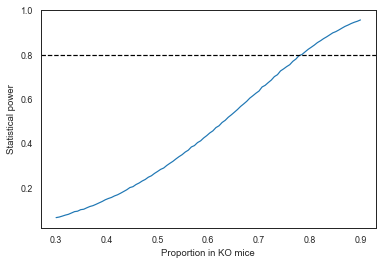

In [28]:
sns.lineplot(p1, power)
plt.axhline(0.8, color = 'black', linestyle = '--');
plt.ylabel('Statistical power')
plt.xlabel('Proportion in KO mice');

In [29]:
np.round(p1[np.argmin(np.abs(power - 0.8))] - 0.3, 2) # Find the location in the p1 array where power is closest to 0.8

0.48

So to get to 80% power, we would need the true difference in proportion to be 0.48, or that at least 78% of KO mice should gain weight on average. This is quite a big difference, and its probably not very interesting scientifically to look for such a big difference, since it's quite unlikely. 

If we could afford 100 mice per arm, what would this look like?

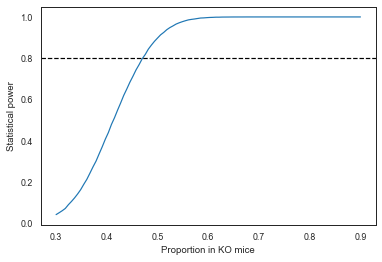

In [30]:
rng = np.random.RandomState(304)
N = 100
weight_gain_wt0 = rng.binomial(N, 0.3, 100000)/N # Get proportion
weight_gain_ko0 = rng.binomial(N, 0.3, 100000)/N # Assume first (null hypothesis) that there is no difference

diff_weight_gain0 = weight_gain_ko0 - weight_gain_wt0
cutoff = np.quantile(diff_weight_gain0, 0.95)

p1 = np.linspace(0.3, 0.9, 100)
power = np.zeros(len(p1))
for i, p in enumerate(p1):
    weight_gain_wt1 = rng.binomial(N, 0.3, 100000)/N
    weight_gain_ko1 = rng.binomial(N, p, 100000)/N
    diff_weight_gain1 = weight_gain_ko1 - weight_gain_wt1
    power[i] = np.mean(diff_weight_gain1 > cutoff)

sns.lineplot(p1, power)
plt.axhline(0.8, color = 'black', linestyle = '--');
plt.ylabel('Statistical power')
plt.xlabel('Proportion in KO mice');

In [31]:
np.round(p1[np.argmin(np.abs(power - 0.8))] - 0.3, 2)

0.17

The minimum detectable difference for 80% power is now down to 0.17, so we'd need the KO mice in truth to show weight gain 47% of the time, compared to 30% in WT mice. This is more reasonable scientifically as a query.

### A permutation test

A permutation test is a 2-group test that asks whether two groups are different with respect to some metric. We'll use the same proteomic data set as before. 

The idea about a permutation test is that, if there is truly no difference then it shouldn't make a difference if we shuffled the labels of ER status over the study individuals. That's literally what we will do. We will do this several times, and look at the average difference in expression each time. This will form the null distribution under our assumption of no differences by ER status. We'll then see where our observed data falls, and then be able to compute a p-value.

The difference between the simulations we just did and a permutation test is that the permutation test is based only on the observed data. No particular models are assumed and no new data is simulated. All we're doing is shuffling the labels among the subjects, but keeping their actual data intact. 

In [32]:
nsim = 10000

rng = np.random.RandomState(294)
x = np.where(brca['ER Status']=='Positive', -1, 1)
y = brca[test_probe].to_numpy()

obs_diff = np.nanmean(y[x==1]) - np.nanmean(y[x==-1])

diffs = np.zeros(nsim)
for i in range(nsim):
    x1 = rng.permutation(x)
    diffs[i] = np.nanmean(y[x1==1]) - np.nanmean(y[x1 == -1])

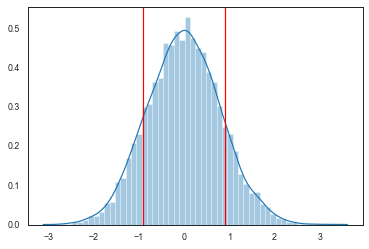

In [33]:
sns.distplot(diffs)
plt.axvline(x = obs_diff, color ='r');
plt.axvline(x = -obs_diff, color = 'r');

In [34]:
pval = np.mean(np.abs(diffs) > np.abs(obs_diff))
f"P-value from permutation test is {pval}"

'P-value from permutation test is 0.2606'

This is pretty close to what we got from the t-test. 

Note that what we've done here is the two-sided test to see how extreme our observation would be in either direction. That is why we've taken the absolute values above, and drawn both the 
observed value and it's negative on the graph. 

### Testing many proteins 

We could do the permutation test all the proteins using the array operations in `numpy`

In [35]:
expr_names = [u for u in list(brca.columns) if u.find('NP') > -1] 
            # Find all column names with NP

exprs = brca[expr_names] # Extract the protein data

In [36]:
x = np.where(brca['ER Status']=='Positive', -1, 1)
obs_diffs = exprs[x==1].mean(axis=0)-exprs[x==-1].mean(axis=0)

In [37]:
nsim = 1000
diffs = np.zeros((nsim, exprs.shape[1]))
for i in range(nsim):
    x1 = rng.permutation(x)
    diffs[i,:] =exprs[x1==1].mean(axis=0) - exprs[x1==-1].mean(axis=0)

In [38]:
pvals = np.zeros(exprs.shape[1])
len(pvals)

12395

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


Text(0.5, 1.0, 'Results of permutation test')

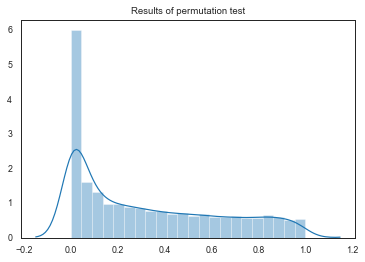

In [39]:
for i in range(len(pvals)):
    pvals[i] = np.mean(np.abs(diffs[:,i]) > np.abs(obs_diffs.iloc[i]))

sns.distplot(pvals);
plt.title('Results of permutation test')

This plot shows that there is probably some proteins which are differentially expressed between ER+ and ER- patients. (If no proteins had any difference, this histogram would be flat, since the p-values would be uniformly distributed). The ideas around Gene Set Enrichment Analysis (GSEA) can also be applied here. 

In [40]:
exprs_shortlist = [u for i, u in enumerate(list(exprs.columns)) 
                   if pvals[i] < 0.0001 ]

len(exprs_shortlist)

896

This means that, if we considered a p-value cutoff for screening at 0.0001, we would select 896 of the 12395 proteins for further study. Note that if none of the proteins had any effect, we'd expect 0.0001 x 12395 or 13 proteins to have a p-value smaller than 0.0001. 

We could also do the same thing using both the t-test and the Mann-Whitney test. 

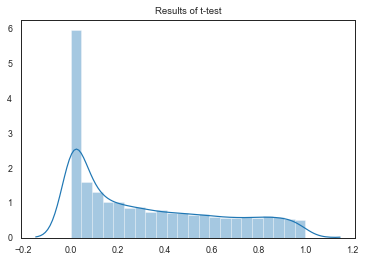

In [41]:
groups = np.where(brca['ER Status']=='Positive', 1, 0)
pvals_t = np.zeros(exprs.shape[1])
for i in range(exprs.shape[1]):
    stat, pvals_t[i] = sc.stats.ttest_ind(exprs.iloc[groups==1, i],
                              exprs.iloc[groups==0, i],
                              nan_policy = 'omit')
sns.distplot(pvals_t);
plt.title('Results of t-test');

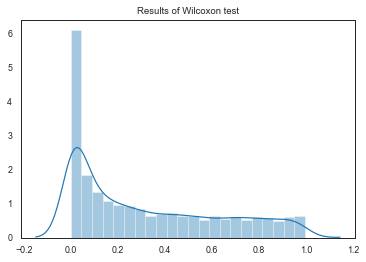

In [42]:
pvals_w = np.zeros(exprs.shape[1])
for i in range(exprs.shape[1]):
    stats, pvals_w[i] = sc.stats.mannwhitneyu(exprs.iloc[groups==1,i], 
                                            exprs.iloc[groups==0, i],
                                             alternative='two-sided')
sns.distplot(pvals_w);
plt.title('Results of Wilcoxon test');

We can directly compare the graphs, which appear quite similar.

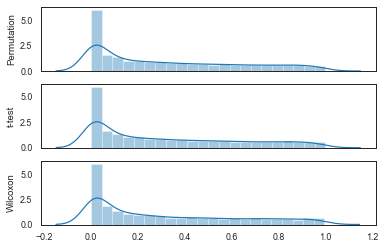

In [43]:
fig, ax = plt.subplots(3,1, sharex = True)

sns.distplot(pvals, ax = ax[0]); ax[0].set_ylabel('Permutation');
sns.distplot(pvals_t, ax = ax[1]); ax[1].set_ylabel('t-test');
sns.distplot(pvals_w, ax = ax[2]); ax[2].set_ylabel('Wilcoxon');

We can also compare how many proteins will be chosen if we employ a p-value cutoff of 0.0001

In [44]:
pvalues = pd.DataFrame({'permutation' : pvals, 'ttest' : pvals_t,
                           'wilcoxon' : pvals_w})
pvalues.apply(lambda x: np.sum(x < 0.0001))

permutation    896
ttest          499
wilcoxon       396
dtype: int64

> The **lambda function** employed above is an anonymous (un-named) function that
can be used on-the-fly. In the above statement, this function takes one (vector) argument *x* and computes the number of *x* values less than 0.0001. This function is then applied to each column of the `pvalues` dataset using the `apply` function.


### Getting a confidence interval using the bootstrap

We can use simulations to obtain a model-free confidence interval for particular parameters of interest based on our observed data. The technique we will demonstrate is called the bootstrap. The idea is that if we sample with replacement from our observed data to get another data set of the same size as the observed data, and compute our statistic of interest, and then repeat this process many times, then the distribution of our statistic that we will obtain this way will be very similar to the true sampling distribution of the statistic if we could "play God". This has strong theoretical foundations from work done by several researchers in the 80s and 90s. 

1. Choose the number of simulations `nsim`
1. for each iteration (1,...,nsim)
    - Simulate a dataset with replacement from the original data. 
    - compute and store the statistic
1. Compute the 2.5th and 97.5th percential of the distribution of the statistic. This is your confidence interval.

Let's see this in action. Suppose we tossed a coin 100 times. We're going to find a confidence interval for the proportion of heads from this coin.

In [45]:
rng = np.random.RandomState(304)
x = rng.binomial(1, 0.7, 100)
x

array([1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1])

This gives the sequence of heads (1) and tails (0), assuming the true probability of heads is 0.7. 

We now create 100000 bootstrap samples from here. 

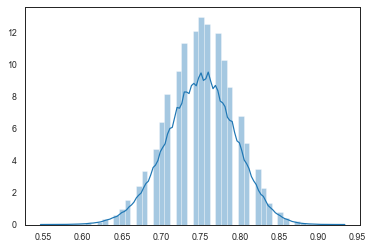

In [46]:
nsim = 100000

boots = np.random.choice(x, (len(x), nsim), replace = True) # sample from the data
boot_estimates = boots.mean(axis = 0) # compute mean of each sample, i.e proportion of heads

sns.distplot(boot_estimates);

In [47]:
np.quantile(boot_estimates, (0.025, 0.975)) # Find 2.5 and 97.5-th percentiles

array([0.66, 0.83])

So our 95% bootstrap confidence interval is (0.66, 0.83). Our true value of 0.7 certainly falls in it. 

## Regression analysis

### Ordinary least squares (linear) regression

The regression modeling frameworks in Python are mainly in `statsmodels`, though some of it can be found in `scikit-learn` which we will see tomorrow. We will use the diamonds dataset for demonstration purposes. We will attempt to model the diamond price against several of the other diamond characteristics.

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf # Use the formula interface to statsmodels

In [49]:
diamonds = sm.datasets.get_rdataset('diamonds','ggplot2').data
mod1 = smf.ols('price ~ np.log(carat) + clarity + depth + cut * color', data = diamonds).fit()


In [50]:
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     4598.
Date:                Wed, 09 Dec 2020   Prob (F-statistic):               0.00
Time:                        12:38:55   Log-Likelihood:            -4.8222e+05
No. Observations:               53940   AIC:                         9.645e+05
Df Residuals:                   53896   BIC:                         9.649e+05
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    2745.0643    415.804      6.602      0.000    1930.085    3560.043
clarity[T.IF]                4916.7221     83.694     58.746      0.000    4752.681    5080.763
clarity[T.SI1]               2686.1493     71.397     37.623      0.000    2546.210    2826.088
clarity[T.SI2]               2060.8180     71.809     28.699      0.000    1920.072    2201.564
clarity[T.VS1]               3710.1759     72.891     50.900      0.000    3567.309    3853.043
clarity[T.VS2]               3438.3999     71.792     47.894      0.000    3297.687    3579.112
clarity[T.VVS1]              4540.1420     77.314     58.724      0.000    4388.606    4691.678
clarity[T.VVS2]              4343.0545     75.136     57.803      0.000    4195.788    4490.321
cut[T.Good]                   708.5981    161.869      4.378      0.000     391.334    1025.862
cut[T.Ideal]                 1198.2067    149.690      8.005      0.000     904.812    1491.601
cut[T.Premium]               1147.1417    152.896      7.503      0.000     847.464    1446.820
cut[T.Very Good]             1011.3463    152.977      6.611      0.000     711.510    1311.183
color[T.E]                    -59.4094    190.227     -0.312      0.755    -432.256     313.437
color[T.F]                    -86.0097    178.663     -0.481      0.630    -436.191     264.172
color[T.G]                   -370.6455    178.642     -2.075      0.038    -720.784     -20.507
color[T.H]                   -591.0922    179.786     -3.288      0.001    -943.474    -238.710
color[T.I]                  -1030.7417    201.485     -5.116      0.000   -1425.655    -635.829
color[T.J]                  -1210.6501    223.111     -5.426      0.000   -1647.949    -773.351
cut[T.Good]:color[T.E]        -30.3553    212.126     -0.143      0.886    -446.123     385.413
cut[T.Ideal]:color[T.E]      -211.3711    195.630     -1.080      0.280    -594.807     172.065
cut[T.Premium]:color[T.E]     -91.3261    199.440     -0.458      0.647    -482.230     299.578
cut[T.Very Good]:color[T.E]   -45.2968    199.656     -0.227      0.821    -436.625     346.031
cut[T.Good]:color[T.F]       -365.4060    202.035     -1.809      0.071    -761.397      30.585
cut[T.Ideal]:color[T.F]      -198.0428    184.498     -1.073      0.283    -559.661     163.575
cut[T.Premium]:color[T.F]    -322.8527    188.465     -1.713      0.087    -692.246      46.540
cut[T.Very Good]:color[T.F]  -186.0519    189.090     -0.984      0.325    -556.670     184.566
cut[T.Good]:color[T.G]        -93.0430    202.404     -0.460      0.646    -489.757     303.671
cut[T.Ideal]:color[T.G]       -65.8579    183.980     -0.358      0.720    -426.461     294.745
cut[T.Premium]:color[T.G]      35.4302    187.596      0.189      0.850    -332.260     403.121
cut[T.Very 

This is the basic syntax for modeling in statsmodels using the *formula* interface. This formula interface mimics the way regression formula are written in R. We will use this formula interface here since it allows for a more concise expression of the regression formula, and handles several things, as we will see. 

> `statsmodels` provides a traditional input syntax as well, where you 
specify the dependent or _endogenous_ variable _y_ as a vector array, and the 
independent or _exogenous_ variables _X_ as a numerical matrix. The typical syntax would be `mod2 = sm.OLS(y, X).fit()`. The formula interface,
which uses the Python package __patsy__, takes care of the conversions, as
well as modifying the design matrix to accommodate interactions and 
transformations.

Let's go through and parse it. 

One thing you notice is that we've written a formula inside the model

```
mod1 = smf.glm('price ~ np.log(carat) + clarity + depth + cut * color', 
    data = diamonds).fit()
```

This formula will read as 
"price depends on log(carat), clarity, depth, cut and color, and the interaction of cut and color". Underneath a lot is going on.

1. color, clarity, and cut are all categorical variables. They actually need to be expanded into dummy variables, so we will have one column for each category level, which is 1 when the diamond is of that category and 0 otherwise. We typically use the **treatment** contrast formulation, which deems one category (usually the first) to be the reference category, and so creates one less dummy variable than the number of category levels, corresponding to the reference level. 
1. An intercept term is added
1. The variable `carat` is transformed using `np.log`, i.e. the natural logarithm available in the `numpy` package. Generally, any valid Python function can be used here, even ones you create. 
1. Interactions are computed. The syntax `cut * color` is a shortcut for `cut + color + cut:color`, where the `:` denotes interaction. 
1. The dummy variables are concatenated to the continuous variables
1. The model is run

To see the full design matrix we can drop down and use **patsy** functions:

In [51]:
import patsy
f = mod1.model.formula
y,X = patsy.dmatrices(f, data = diamonds, return_type = 'dataframe')

_X_ is the full design matrix with all the transformations and dummy variables and interactions computed, as specified by the formula.

Suppose we wanted the Ideal cut of diamond to be the reference level for the `cut` variable. We could specify this within the formula quite simply as:

In [52]:
mod2 = smf.ols('price ~ np.log(carat) + clarity + depth + C(cut, Treatment("Ideal")) * color', data = diamonds).fit()

This syntax says that we consider `cut` to be a categorical variable, 
from which we will create dummy variables using _treatment_ contrasts, 
using Ideal as the reference level. 

### Logistic regression

Logistic regression is the usual regression method used when you have
binary outcomes, e.g., Yes/No, Negative/Positive, etc. 

Logistic regression does exist as an individual method in **scikit-learn**, whic we will see in the Machine Learning module. However, it resides in its more traditional form within the _generalized linear model_ framework in __statsmodels__

We will use a dataset based on deaths from the Titanic disaster in 1912. 

In [53]:
titanic = sm.datasets.get_rdataset('Titanic','Stat2Data').data
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      1313 non-null   object 
 1   PClass    1313 non-null   object 
 2   Age       756 non-null    float64
 3   Sex       1313 non-null   object 
 4   Survived  1313 non-null   int64  
 5   SexCode   1313 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 61.7+ KB


We will model `Survived` on the age, sex and passenger class of passengers. 

In [54]:
mod_logistic = smf.glm('Survived ~ Age + Sex + PClass', data=titanic,
  family = sm.families.Binomial()).fit()
mod_logistic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  756
Model:                            GLM   Df Residuals:                      751
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -347.57
Date:                Wed, 09 Dec 2020   Deviance:                       695.14
Time:                        12:38:57   Pearson chi2:                     813.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.8664      0.217      8.587      0.000       1.440       2.292
Sex[T.male]      -2.6314      0.202    -13.058      0.000      -3.026      -2.236
PClass[T.1st]     1.8933      0.208      9.119      0.000       1.486       2.300
PClass[T.2nd]     0.6013      0.148      4.052      0.000       0.310       0.892
PClass[T.3rd]    -0.6282      0.132     -4.754      0.000      -0.887      -0.369
Age              -0.0392      0.008     -5.144      0.000      -0.054      -0.024
=================================================================================
"""

The `family = sm.families.Binomial()` tells us that we're fitting a logistic
regression, since we are stating that the outcomes are from a Binomial distribution. (See the [API documentation](https://www.statsmodels.org/stable/glm.html#families) for a list of available distributions for GLMs). 

The coefficients in a logistic regression are the _log-odds ratios_. To get the odds ratios, we would need to exponentiate them. 


In [55]:
np.exp(mod_logistic.params.drop('Intercept'))

Sex[T.male]      0.071981
PClass[T.1st]    6.640989
PClass[T.2nd]    1.824486
PClass[T.3rd]    0.533574
Age              0.961581
dtype: float64

> The intercept term in a logistic regression is **not** a log-odds ratio, so we omit it by using the `drop` function. 

### Survival analysis

Survival analysis or reliability analysis deals typically with data on 
time to an event, where this time can be _censored_ at the end of observation. Examples include time to death for cancer patients, time to failure of a car transmission, etc. Censoring would mean that the subject is still alive/working when we last observed. 

A common regression method for survival data is Cox proportional hazards regression. As an example, we will use a data set from a VA lung cancer study. 

In [56]:
veteran = sm.datasets.get_rdataset('veteran', 'survival').data

mod_cph = smf.phreg('time ~ C(trt) + celltype + age + C(prior)',
  data = veteran, status = veteran.status).fit()
mod_cph.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: PHReg
===========================================================================
Model:                         PH Reg            Sample size:           137
Dependent variable:            time              Num. events:           128
Ties:                          Breslow                                     
---------------------------------------------------------------------------
                       log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
---------------------------------------------------------------------------
C(trt)[T.2]            0.1734    0.2016 1.1893  0.8600 0.3898 0.8011 1.7655
celltype[T.large]     -0.8817    0.2962 0.4141 -2.9761 0.0029 0.2317 0.7400
celltype[T.smallcell] -0.0956    0.2649 0.9088 -0.3609 0.7182 0.5407 1.5275
celltype[T.squamous]  -1.1738    0.2997 0.3092 -3.9173 0.0001 0.1718 0.5563
C(prior)[T.10]         0.0378    0.2064 1.0385  0.1833 0.8546 0.6930 1.5563
age                    0.0042    0.0096 1.0042  0.4401 0.6598 0.9855 1.0233
===========================================================================
Confidence intervals are for the hazard ratios
"""

> For survival regression, we need to input the status of the subject 
at time of last follow-up, coded as 1 for failure/death, 0 for censored.

**Question:** Why did I use `C(trt)` instead of `trt` in the formula?

We can do a few more basic things for this data. First, let's draw the 
survival curve, which plots the proportion of subjects still alive against time, using the Kaplan-Meier method.

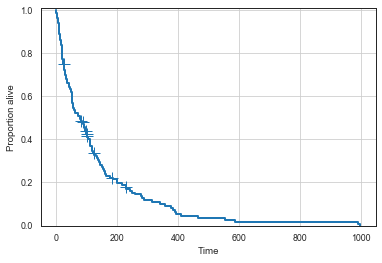

In [57]:
sf = sm.duration.SurvfuncRight(veteran.time, veteran.status)
sf.plot();
plt.grid(True);
plt.xlabel('Time');
plt.ylabel('Proportion alive');
plt.show()

Suppose we now want to see if there is any difference between treatment groups.

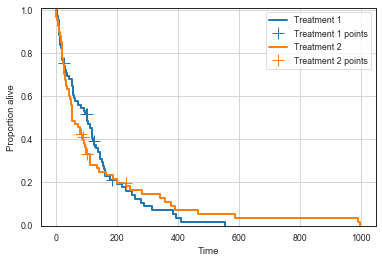

In [58]:
sf1 = sm.duration.SurvfuncRight(veteran.time[veteran.trt==1], veteran.status[veteran.trt==1], title='Treatment 1')
sf2 = sm.duration.SurvfuncRight(veteran.time[veteran.trt==2], veteran.status[veteran.trt==2], title='Treatment 2')

fig, ax = plt.subplots()

plt.grid(True)
sf1.plot(ax); # Draw on previously defined axis
sf2.plot(ax);

plt.xlabel('Time');
plt.ylabel('Proportion alive');
plt.legend(loc='upper right');
plt.show()

We could also perform a statistical test (the _log-rank test_) to see
if there is a statistical difference between these two curves.


In [59]:
chisq, pval = sm.duration.survdiff(veteran.time, veteran.status, veteran.trt)
np.round(pval,3)

0.928